# EZBattery demo
------------------------------------------
## Organic electrolyte redox flow battery
------------------------------------------
## Table of contents
### 1. Import all the necessary packages
### 2. Load in the cell metadata
### 3. Load in the experiment data
### 4. Model calibration
#### 4.1. Adjust the parameters for the single cycle calibration
#### 4.2. Run the auto calibration
#### 4.3 Show the model estimation with the calibrated cell properties
### 5. EZBattery and COMSOL comparision
#### 5.1 Load in the cell metadata
#### 5.2 Run the model
#### 5.3 Load in the COMOSL simulation data
#### 5.4 Comparing the results from EZBattery and COMSOL

### 1. Import all the necessary packages

In [15]:
import os, copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from EZBattery import BatteryParameter,LoadExperiment, RFB
from EZBattery import Calibration,CellLossFunction
import pandas as pd

### 2. Load in the cell metadata

In [3]:
WorkDir = os.getcwd() + os.sep + 'data' 
SDPFNames = 'SDPF_Phenazine_20240630_V5.xlsx'
SDPFPath = WorkDir + os.sep + SDPFNames
PP = BatteryParameter(SDPFPath)

### 3. Load in the experiment data

In [4]:
PP0 = copy.deepcopy(PP)
PP0.CalibrationOutputPath = SDPFPath
fname = PP0.Experiment.split('\\')[-1]
EXPPath = WorkDir + os.sep + fname
PP0.Experiment = EXPPath
F = LoadExperiment(PP0)

Loading experiment data from D:\ROVI\EZBattery_python\EZBattery_Demo\EZBattery_Demo\data\SK04292022_ID10_71V2_2HC23_1ElaH_AORFB_60mL_min_Channel_8_Wb_1.xlsx.


### 4. Model calibration
#### 4.1. Adjust the parameters for the single cycle calibration. 
##### In this example, four cell properties are selected for calibration to make the model prediction matching the experiment data better. 
1) mass transport coefficient in porous electrode (0.1-100)
2) membrane conductivity (0.01-2)
3) reaction rate constant in anode side (1e-9 - 1e-4)
4) reaction rate constant in cathode side (1e-9 - 1e-4)

In [7]:
PP0.Display = 'no'
PP0.SolverType = 'ODEImplicit'
PP0.TimeStep = 500
PP0.RefineTimePoints = 1
PP0.RefineTimeTimes = 1
PPS = copy.deepcopy(PP0)
PPS.NumberOfProcessor = 1
PPS.PopulationSize = 20
PPS.MaxIteration = 150
PPS.CalibrationCycleStart = 1
PPS.CalibrationCycleEnd = 1
PPS.BoundsSingle = [(0.1,100),(0.01,2),(1e-9,1e-4),(1e-9,1e-4)]
PPS.DisplayDifferentialEvolution = 'yes'
PPS.CalibrationDisplay = 'no'
PPS.CalibrationDisplayDebug = 'no'
PPS.CalibrationMode = 'Single'
PPS.DecayMode = 'None'

#### 4.2. Run the auto calibration
##### Calibration control for single cycle. 1 cycle calibration: reference calibrated parameters, setups, and time. nCPU = 1, nPop = 20, dt = 500; t = 28 s (fastest, less accurate)
x0 = [5.87560562e+00, 1.14801507e+00, 5.54882079e-05, 1.87180225e-05]

In [8]:
Res0 = Calibration(PPS, F)
x0 = Res0.x


EZBattery calibration for cycle 1.
differential_evolution step 1: f(x)= 103.334
Solution: [5.32288655e+00 1.10005991e+00 4.96208929e-05 5.66572784e-06], Convergence: 0.13643090367795677
differential_evolution step 2: f(x)= 98.0961
Solution: [6.47784840e+00 1.02236924e+00 6.33170729e-05 6.85869072e-06], Convergence: 0.1343344814681539
differential_evolution step 3: f(x)= 98.0961
Solution: [6.47784840e+00 1.02236924e+00 6.33170729e-05 6.85869072e-06], Convergence: 0.12737038998366526
differential_evolution step 4: f(x)= 95.462
Solution: [6.17033016e+00 1.56450166e+00 7.52169554e-05 4.40603957e-06], Convergence: 0.10442821184928475
differential_evolution step 5: f(x)= 95.462
Solution: [6.17033016e+00 1.56450166e+00 7.52169554e-05 4.40603957e-06], Convergence: 0.09923772467909579
differential_evolution step 6: f(x)= 95.462
Solution: [6.17033016e+00 1.56450166e+00 7.52169554e-05 4.40603957e-06], Convergence: 0.10862126163995672
differential_evolution step 7: f(x)= 95.1467
Solution: [5.8566

#### 4.3 Show the model estimation with the calibrated cell properties
##### User can directly try the calibrated properties 
x0 = [5.87560562e+00, 1.14801507e+00, 5.54882079e-05, 1.87180225e-05]

Parameter: 5.87, 1.52, 9.91e-05, 1.97e-05; Loss: 16.7, 16.7 mV, 0.0 s
Running a multi-cycle unit cell model.
Active species: ['Ferrocyanide', 'Ferricyanide', 'DHPS', 'HydratedDHPS'].
Non active species: ['Water', 'Hydroxide'].
Membrane species: ['SodiumIon'].

Cycle 1: charge 0.563 h, discharge 0.557 h, CE: 0.991, Cumulative CE 0.991 (40.9%).
Computation done, elapsed time 1.119 seconds, average time per cycle 1.119 seconds.



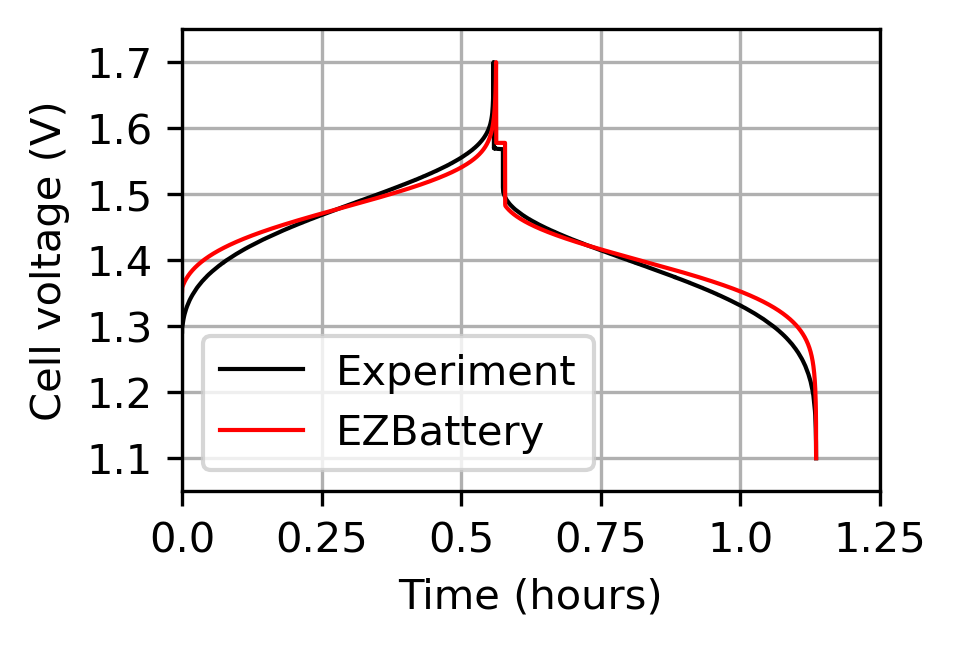

In [9]:
PPS.CalibrationDisplay = 'yes'
PPS.CalibrationType = 'debug'
PPS.TimeStep = 10
Rec1 = CellLossFunction(x0,PPS,F)
param = x0
PP.TimmeStep = 10
PP.CathodeMassTransportCoefficient = param[0]
PP.AnodeMassTransportCoefficient = param[0]
PP.MembraneIonDragCoefficient = param[1]
PP.CathodeReactionRateConstant = param[2]
PP.AnodeReactionRateConstant = param[3]
Re = RFB(PP)

sd = 3600
ncx = PPS.CalibrationCycleEnd - PPS.CalibrationCycleEnd + 1
FV = F[F[:,3]<=ncx,:]
plt.figure(figsize=(3,2),dpi=300)
plt.plot(FV[:,0]/sd, FV[:, 1],'-',color='black',mfc='none',markersize=1,markevery=1,label="Experiment",linewidth=1)
plt.plot(Re['Potentials']['Time_s']/sd,Re['Potentials']['Ec_V'],'-',color='red',label='EZBattery',markersize=1,linewidth=1)

plt.xlabel('Time (hours)')
plt.ylabel('Cell voltage (V)')
tmax = np.ceil(max(Re['Potentials']['Time_s'])/sd)

n_labels_x = 8
labels_x = np.arange(0,tmax,tmax/n_labels_x)
labels_y = np.arange(1.1,1.8,0.1)
plt.xticks(labels_x, labels_x)
plt.yticks(labels_y, labels_y)
ax = plt.gca()
ax.set_xlim([0,1.25])
ax.set_ylim([1.05,1.75])
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.grid()
plt.legend() 
plt.show()
plt.close()

## 5. EZBattery and COMSOL comparision
#### This example shows the comparison between the EZBattery model estimation on the large cell performance. The cell is 780cm2 interdigitated cell. The electrolyte is one of potential Phenazine-based derivatives. Comparing the EZBattery model estimation with the COMSOL 3D FEM simulation. The COMSOL simulation took a few hours on HPC. There is NO calibration needed for EZBattery. Both models, EZBattery and COMSOL, used the same properties and paramters from the cell and chemicals.

#### 5.1 Load in the cell metadata

In [12]:
WorkDir = WorkDir = os.getcwd() + os.sep + 'data'           
SDPFNames = 'SDPF_Phenazine_20240725_V5_Comsol.xlsx'
SDPFPath = WorkDir + os.sep + SDPFNames
PP1 = BatteryParameter(SDPFPath)

#### 5.2 Run the model

In [13]:
Re1 = RFB(PP1)

Running a multi-cycle unit cell model.
Active species: ['Ferrocyanide', 'Ferricyanide', 'DHPS', 'HydratedDHPS'].
Non active species: ['Water', 'Hydroxide'].
Membrane species: ['SodiumIon'].

Cycle 1: charge 0.500 h, discharge 0.406 h, CE: 0.811, Cumulative CE 0.811 (6.6%).
Computation done, elapsed time 0.794997 seconds, average time per cycle 0.794997 seconds.



#### 5.3 Load in the COMSOL simulation data

In [18]:
PP0 = copy.deepcopy(PP1)
fname = PP1.Experiment.split('\\')[-1]
EXPPath = WorkDir + os.sep + fname
print(EXPPath)
FC = pd.read_csv(EXPPath)     

D:\ROVI\EZBattery_python\EZBattery_Demo\EZBattery_Demo\data\Comsol_Phenazine.csv


#### 5.4 Comparing the results from EZBattery and COMSOL

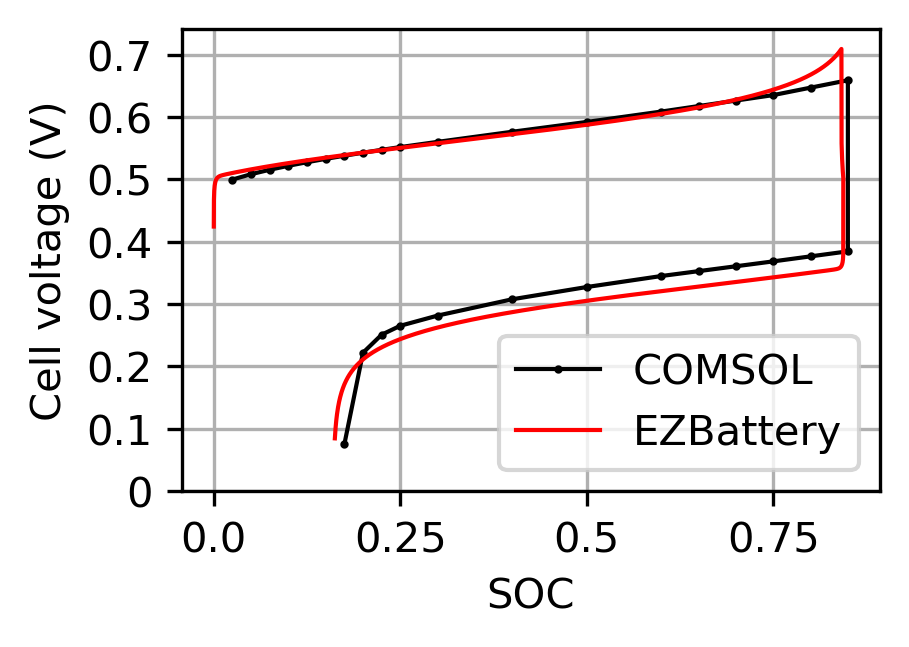

In [20]:
#%% Plottings.
sd = 3600
plt.figure(figsize=(3,2),dpi=300)
plt.plot(FC['SOC_neg'], FC['cell_potential_V'],'o-',color='black',mfc='none',markersize=1,markevery=1,label="COMSOL",linewidth=1)
plt.plot(Re1['Potentials']['SOC'],Re1['Potentials']['Ec_V'],'-',color='red',label='EZBattery',markersize=1,linewidth=1)

plt.xlabel('SOC')
plt.ylabel('Cell voltage (V)')
tmax = np.ceil(max(Re1['Potentials']['Time_s'])/sd)

labels_x = np.arange(0,1,0.25)
labels_y = np.arange(0,0.8,0.1)
plt.xticks(labels_x, labels_x)
plt.yticks(labels_y, labels_y)
ax = plt.gca()
# ax.set_xlim([0,1.25])
# ax.set_ylim([1.05,1.75])
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.grid()
plt.legend() 
plt.show()
plt.close()